<a href="https://colab.research.google.com/github/jasleenkaursandhu/Reproducing-chest-xray-report-generation-boag/blob/main/chexpert_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# CheXpert Evaluation for Chest X-Ray Report Generation Models
# Modified to include different neighbor variations (10, 50, 100, 200)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, accuracy_score
import os
import subprocess
from time import strftime, gmtime

# Define paths
base_path = '/Users/simeon/Documents/DLH/content/mimic-cxr-project/'  # For local machine
# base_path = '/content/drive/MyDrive/mimic-cxr-project'  # For Google Colab
output_dir = os.path.join(base_path, 'output')

In [8]:
def process_reference_files(input_files, output_prefix="", base_path=None):
    """Converts TSV files to headerless CSV files with text content only."""
    import csv, os
    from time import strftime, gmtime

    results = {}

    for input_file in input_files:
        file_base = os.path.splitext(os.path.basename(input_file))[0]
        output_file = f"{output_prefix}{file_base}.csv"

        input_path = input_file
        output_path = output_file

        if base_path:
            if not os.path.isabs(input_file):
                input_path = os.path.join(base_path, input_file)
            output_path = os.path.join(base_path, "output", output_file)

        ref_reports = {}

        with open(input_path, 'r') as f:
            first_line = f.readline().strip()
            has_header = 'dicom_id' in first_line and '\t' in first_line

            if not has_header:
                parts = first_line.split('\t')
                if len(parts) >= 2:
                    ref_reports[parts[0]] = '\t'.join(parts[1:])

            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 2:
                    ref_reports[parts[0]] = '\t'.join(parts[1:])

        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        with open(output_path, 'w', newline='') as f:
            writer = csv.writer(f, quoting=csv.QUOTE_MINIMAL)
            for _, text in sorted(ref_reports.items()):
                writer.writerow([text])

        print(f"Processed {len(ref_reports)} reports from {input_file}")
        print(f"Output written to {output_path}")

        results[file_base] = ref_reports

    print(f"Completed processing {len(input_files)} files at {strftime('%Y-%m-%d %H:%M:%S', gmtime())}")

    return results

In [9]:
# Prepare list of all input files including neighbor variations
input_files = [
    "output/random.tsv",
    "output/1-gram.tsv",
    "output/2-gram.tsv",
    "output/3-gram.tsv",
    "output/reference.tsv",
    "output/1nn_reports.tsv"
]

# Add n-gram models with different neighbor counts
for n in [1, 2, 3]:
    for k in [10, 50, 100, 200]:
        input_files.append(f"output/{n}-gram_{k}nn.tsv")

In [10]:
# Process all files
print("Processing TSV files to CSV format...")
results = process_reference_files(input_files, output_prefix="", base_path=base_path)

Processing TSV files to CSV format...
Processed 1757 reports from output/random.tsv
Output written to /Users/simeon/Documents/DLH/content/mimic-cxr-project/output/random.csv
Processed 1727 reports from output/1-gram.tsv
Output written to /Users/simeon/Documents/DLH/content/mimic-cxr-project/output/1-gram.csv
Processed 1757 reports from output/2-gram.tsv
Output written to /Users/simeon/Documents/DLH/content/mimic-cxr-project/output/2-gram.csv
Processed 1757 reports from output/3-gram.tsv
Output written to /Users/simeon/Documents/DLH/content/mimic-cxr-project/output/3-gram.csv
Processed 1757 reports from output/reference.tsv
Output written to /Users/simeon/Documents/DLH/content/mimic-cxr-project/output/reference.csv
Processed 1757 reports from output/1nn_reports.tsv
Output written to /Users/simeon/Documents/DLH/content/mimic-cxr-project/output/1nn_reports.csv
Processed 1722 reports from output/1-gram_10nn.tsv
Output written to /Users/simeon/Documents/DLH/content/mimic-cxr-project/output/

In [11]:
# Run CheXpert labeler on all CSV files
print("\nRunning CheXpert labeler on all processed files...")
docker_image_name = 'uwizeye2/chexpert-labeler:amd64'

# Process each file with CheXpert labeler
csv_files = [os.path.basename(file).replace('.tsv', '.csv') for file in input_files]

# First, ensure any container is not running
subprocess.run(f"docker ps -a --format '{{{{.Names}}}}' | grep -q '^my_container$' && docker rm -f my_container", shell=True)

# Process each file
for file in csv_files:
    input_path = f"/data/{file}"
    output_path = f"/data/labeled_{file}"

    # Skip if output already exists to save time
    if os.path.exists(os.path.join(output_dir, f"labeled_{file}")):
        print(f"Labeled file for {file} already exists, skipping...")
        continue

    print(f"Processing {file} with CheXpert labeler...")

    # Run the command directly with docker run
    command = f"docker run --rm --platform linux/amd64 -v {base_path}output:/data {docker_image_name} python label.py --reports_path {input_path} --output_path {output_path} --verbose"

    # Execute the command
    print(f"Executing: {command}")
    result = subprocess.run(command, shell=True)

    if result.returncode != 0:
        print(f"Error processing {file}, return code: {result.returncode}")
    else:
        print(f"Successfully processed {file}")

    print("-" * 50)

print("All files processed with CheXpert labeler!")


Running CheXpert labeler on all processed files...
Labeled file for random.csv already exists, skipping...
Labeled file for 1-gram.csv already exists, skipping...
Labeled file for 2-gram.csv already exists, skipping...
Labeled file for 3-gram.csv already exists, skipping...
Labeled file for reference.csv already exists, skipping...
Labeled file for 1nn_reports.csv already exists, skipping...
Processing 1-gram_10nn.csv with CheXpert labeler...
Executing: docker run --rm --platform linux/amd64 -v /Users/simeon/Documents/DLH/content/mimic-cxr-project/output:/data uwizeye2/chexpert-labeler:amd64 python label.py --reports_path /data/1-gram_10nn.csv --output_path /data/labeled_1-gram_10nn.csv --verbose


 20%|█▉        | 340/1722 [04:54<22:03,  1.04it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 28%|██▊       | 479/1722 [07:13<21:32,  1.04s/it]ERROR:root:No parse tree for sentence: 0
NoneType: None
 44%|████▍     | 764/1722 [12:46<35:56,  2.25s/it]ERROR:root:No parse tree for sentence: 0
NoneType: None
 46%|████▌     | 788/1722 [13:07<11:19,  1.37it/s]ERROR:root:Cannot process sentence 480 in 789
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 59%|█████▊    | 1011/1722 [17:09<05:30,  2.15it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 73%|███████▎  | 1253/1722 [22:01<29:39,  3.79s/it]ERROR:root:No parse tree for sentence: 59
NoneType: None
 87%|████████▋ | 1498/1722 [26:50<03:24,  1.09it/s]ERROR:root:Cannot process sentence 30 in 1498
Traceback (most recent call last):
  File "/app/chexpert-labele

Loading mention phrases for 14 observations.
Loading unmention phrases for 3 observations.
Extracting mentions...
Classifying mentions...
Aggregating mentions...
Writing reports and labels to /data/labeled_1-gram_10nn.csv.
Successfully processed 1-gram_10nn.csv
--------------------------------------------------
Processing 1-gram_50nn.csv with CheXpert labeler...
Executing: docker run --rm --platform linux/amd64 -v /Users/simeon/Documents/DLH/content/mimic-cxr-project/output:/data uwizeye2/chexpert-labeler:amd64 python label.py --reports_path /data/1-gram_50nn.csv --output_path /data/labeled_1-gram_50nn.csv --verbose


  4%|▍         | 66/1727 [01:15<29:39,  1.07s/it]ERROR:root:No parse tree for sentence: 0
NoneType: None
 10%|█         | 180/1727 [02:44<09:08,  2.82it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 17%|█▋        | 297/1727 [04:33<28:28,  1.20s/it]ERROR:root:Cannot process sentence 450 in 297
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 23%|██▎       | 394/1727 [05:54<18:24,  1.21it/s]ERROR:root:Cannot process sentence 166 in 394
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 27%|██▋       | 459/1727 [07:25<42:01,  1.99s/it]  ERROR:root:Cannot process sentence 90 in 459
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio

Loading mention phrases for 14 observations.
Loading unmention phrases for 3 observations.
Extracting mentions...
Classifying mentions...
Aggregating mentions...
Writing reports and labels to /data/labeled_1-gram_50nn.csv.
Successfully processed 1-gram_50nn.csv
--------------------------------------------------
Processing 1-gram_100nn.csv with CheXpert labeler...
Executing: docker run --rm --platform linux/amd64 -v /Users/simeon/Documents/DLH/content/mimic-cxr-project/output:/data uwizeye2/chexpert-labeler:amd64 python label.py --reports_path /data/1-gram_100nn.csv --output_path /data/labeled_1-gram_100nn.csv --verbose


  1%|▏         | 25/1715 [00:20<11:56,  2.36it/s] ERROR:root:Cannot process sentence 576 in 25
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 21%|██        | 357/1715 [05:58<21:28,  1.05it/s]  ERROR:root:Cannot process sentence 0 in 357
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 23%|██▎       | 400/1715 [06:26<11:54,  1.84it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 26%|██▌       | 446/1715 [07:02<15:14,  1.39it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 33%|███▎      | 559/1715 [08:55<17:27,  1.10it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 40%|████      | 692/1715 [11:23<10:16,  1.66it/s]  ERROR:root:No par

Loading mention phrases for 14 observations.
Loading unmention phrases for 3 observations.
Extracting mentions...
Classifying mentions...
Aggregating mentions...
Writing reports and labels to /data/labeled_1-gram_100nn.csv.
Successfully processed 1-gram_100nn.csv
--------------------------------------------------
Processing 1-gram_200nn.csv with CheXpert labeler...
Executing: docker run --rm --platform linux/amd64 -v /Users/simeon/Documents/DLH/content/mimic-cxr-project/output:/data uwizeye2/chexpert-labeler:amd64 python label.py --reports_path /data/1-gram_200nn.csv --output_path /data/labeled_1-gram_200nn.csv --verbose


 14%|█▍        | 248/1720 [04:16<45:35,  1.86s/it]  ERROR:root:Cannot process sentence 207 in 248
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 33%|███▎      | 566/1720 [09:49<23:13,  1.21s/it]  ERROR:root:Cannot process sentence 311 in 567
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 34%|███▎      | 580/1720 [09:57<15:29,  1.23it/s]ERROR:root:Cannot process sentence 111 in 580
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 34%|███▍      | 587/1720 [10:14<41:59,  2.22s/it]  ERROR:root:Cannot proce

Loading mention phrases for 14 observations.
Loading unmention phrases for 3 observations.
Extracting mentions...
Classifying mentions...
Aggregating mentions...
Writing reports and labels to /data/labeled_1-gram_200nn.csv.
Successfully processed 1-gram_200nn.csv
--------------------------------------------------
Processing 2-gram_10nn.csv with CheXpert labeler...
Executing: docker run --rm --platform linux/amd64 -v /Users/simeon/Documents/DLH/content/mimic-cxr-project/output:/data uwizeye2/chexpert-labeler:amd64 python label.py --reports_path /data/2-gram_10nn.csv --output_path /data/labeled_2-gram_10nn.csv --verbose


 10%|█         | 181/1757 [01:32<19:30,  1.35it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 13%|█▎        | 220/1757 [01:45<06:18,  4.06it/s]ERROR:root:No parse tree for sentence: 92
NoneType: None
 44%|████▍     | 771/1757 [06:53<13:14,  1.24it/s]ERROR:root:Cannot process sentence 0 in 771
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 50%|████▉     | 877/1757 [07:41<10:28,  1.40it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 65%|██████▍   | 1134/1757 [10:12<07:57,  1.31it/s]ERROR:root:Cannot process sentence 160 in 1134
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 67%|██████▋   | 1171/1757 [10:26<04:13,  2.31it/s]ERROR:root:No pa

Loading mention phrases for 14 observations.
Loading unmention phrases for 3 observations.
Extracting mentions...
Classifying mentions...
Aggregating mentions...
Writing reports and labels to /data/labeled_2-gram_10nn.csv.
Successfully processed 2-gram_10nn.csv
--------------------------------------------------
Processing 2-gram_50nn.csv with CheXpert labeler...
Executing: docker run --rm --platform linux/amd64 -v /Users/simeon/Documents/DLH/content/mimic-cxr-project/output:/data uwizeye2/chexpert-labeler:amd64 python label.py --reports_path /data/2-gram_50nn.csv --output_path /data/labeled_2-gram_50nn.csv --verbose


  2%|▏         | 38/1757 [00:14<08:34,  3.34it/s]ERROR:root:Cannot process sentence 154 in 38
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
  8%|▊         | 147/1757 [01:13<08:57,  3.00it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 10%|█         | 179/1757 [01:35<22:53,  1.15it/s]ERROR:root:Cannot process sentence 94 in 179
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 14%|█▍        | 253/1757 [02:10<18:09,  1.38it/s]ERROR:root:Cannot process sentence 31 in 253
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' 

Loading mention phrases for 14 observations.
Loading unmention phrases for 3 observations.
Extracting mentions...
Classifying mentions...
Aggregating mentions...
Writing reports and labels to /data/labeled_2-gram_50nn.csv.
Successfully processed 2-gram_50nn.csv
--------------------------------------------------
Processing 2-gram_100nn.csv with CheXpert labeler...
Executing: docker run --rm --platform linux/amd64 -v /Users/simeon/Documents/DLH/content/mimic-cxr-project/output:/data uwizeye2/chexpert-labeler:amd64 python label.py --reports_path /data/2-gram_100nn.csv --output_path /data/labeled_2-gram_100nn.csv --verbose


 22%|██▏       | 383/1757 [03:18<17:30,  1.31it/s]ERROR:root:Cannot process sentence 258 in 383
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 24%|██▍       | 426/1757 [04:00<07:34,  2.93it/s]  ERROR:root:Cannot process sentence 29 in 426
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 36%|███▌      | 627/1757 [05:56<13:19,  1.41it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 39%|███▊      | 679/1757 [06:30<17:44,  1.01it/s]ERROR:root:Cannot process sentence 128 in 679
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneT

Loading mention phrases for 14 observations.
Loading unmention phrases for 3 observations.
Extracting mentions...
Classifying mentions...
Aggregating mentions...
Writing reports and labels to /data/labeled_2-gram_100nn.csv.
Successfully processed 2-gram_100nn.csv
--------------------------------------------------
Processing 2-gram_200nn.csv with CheXpert labeler...
Executing: docker run --rm --platform linux/amd64 -v /Users/simeon/Documents/DLH/content/mimic-cxr-project/output:/data uwizeye2/chexpert-labeler:amd64 python label.py --reports_path /data/2-gram_200nn.csv --output_path /data/labeled_2-gram_200nn.csv --verbose


 16%|█▌        | 284/1757 [02:51<21:28,  1.14it/s]ERROR:root:Cannot process sentence 0 in 284
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 55%|█████▌    | 970/1757 [09:23<09:27,  1.39it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 68%|██████▊   | 1198/1757 [12:16<07:38,  1.22it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 71%|███████   | 1243/1757 [12:52<03:55,  2.19it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 72%|███████▏  | 1271/1757 [13:07<08:25,  1.04s/it]ERROR:root:Cannot process sentence 275 in 1271
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 80%|████████  | 1412/1757 [14:19<03:11,  1.81it/s]ERROR:root:Cann

Loading mention phrases for 14 observations.
Loading unmention phrases for 3 observations.
Extracting mentions...
Classifying mentions...
Aggregating mentions...
Writing reports and labels to /data/labeled_2-gram_200nn.csv.
Successfully processed 2-gram_200nn.csv
--------------------------------------------------
Processing 3-gram_10nn.csv with CheXpert labeler...
Executing: docker run --rm --platform linux/amd64 -v /Users/simeon/Documents/DLH/content/mimic-cxr-project/output:/data uwizeye2/chexpert-labeler:amd64 python label.py --reports_path /data/3-gram_10nn.csv --output_path /data/labeled_3-gram_10nn.csv --verbose


  0%|          | 7/1757 [00:02<14:29,  2.01it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 10%|█         | 179/1757 [01:00<07:16,  3.61it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 14%|█▍        | 246/1757 [01:30<10:02,  2.51it/s]ERROR:root:Cannot process sentence 129 in 246
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 24%|██▍       | 426/1757 [02:38<13:44,  1.61it/s]ERROR:root:Cannot process sentence 0 in 426
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 24%|██▍       | 428/1757 [02:39<16:16,  1.36it/s]ERROR:root:Cannot process sentence 623 in 428
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pip

Loading mention phrases for 14 observations.
Loading unmention phrases for 3 observations.
Extracting mentions...
Classifying mentions...
Aggregating mentions...
Writing reports and labels to /data/labeled_3-gram_10nn.csv.
Successfully processed 3-gram_10nn.csv
--------------------------------------------------
Processing 3-gram_50nn.csv with CheXpert labeler...
Executing: docker run --rm --platform linux/amd64 -v /Users/simeon/Documents/DLH/content/mimic-cxr-project/output:/data uwizeye2/chexpert-labeler:amd64 python label.py --reports_path /data/3-gram_50nn.csv --output_path /data/labeled_3-gram_50nn.csv --verbose


 24%|██▎       | 415/1757 [02:54<08:30,  2.63it/s]ERROR:root:No parse tree for sentence: 0
NoneType: None
 50%|████▉     | 878/1757 [06:18<12:37,  1.16it/s]ERROR:root:Cannot process sentence 635 in 878
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 64%|██████▍   | 1122/1757 [08:02<04:41,  2.25it/s]ERROR:root:Cannot process sentence 68 in 1122
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 74%|███████▎  | 1293/1757 [09:18<10:57,  1.42s/it]ERROR:root:Cannot process sentence 437 in 1293
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'Non

Loading mention phrases for 14 observations.
Loading unmention phrases for 3 observations.
Extracting mentions...
Classifying mentions...
Aggregating mentions...
Writing reports and labels to /data/labeled_3-gram_50nn.csv.
Successfully processed 3-gram_50nn.csv
--------------------------------------------------
Processing 3-gram_100nn.csv with CheXpert labeler...
Executing: docker run --rm --platform linux/amd64 -v /Users/simeon/Documents/DLH/content/mimic-cxr-project/output:/data uwizeye2/chexpert-labeler:amd64 python label.py --reports_path /data/3-gram_100nn.csv --output_path /data/labeled_3-gram_100nn.csv --verbose


  9%|▉         | 155/1757 [01:10<13:58,  1.91it/s]ERROR:root:Cannot process sentence 279 in 155
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 15%|█▌        | 271/1757 [01:53<04:42,  5.26it/s]ERROR:root:Cannot process sentence 44 in 271
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 26%|██▌       | 458/1757 [03:15<12:29,  1.73it/s]ERROR:root:Cannot process sentence 598 in 459
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 32%|███▏      | 571/1757 [04:07<06:44,  2.93it/s]ERROR:root:No parse tree for s

Loading mention phrases for 14 observations.
Loading unmention phrases for 3 observations.
Extracting mentions...
Classifying mentions...
Aggregating mentions...
Writing reports and labels to /data/labeled_3-gram_100nn.csv.
Successfully processed 3-gram_100nn.csv
--------------------------------------------------
Processing 3-gram_200nn.csv with CheXpert labeler...
Executing: docker run --rm --platform linux/amd64 -v /Users/simeon/Documents/DLH/content/mimic-cxr-project/output:/data uwizeye2/chexpert-labeler:amd64 python label.py --reports_path /data/3-gram_200nn.csv --output_path /data/labeled_3-gram_200nn.csv --verbose


  4%|▍         | 68/1757 [00:31<09:45,  2.88it/s]ERROR:root:Cannot process sentence 0 in 68
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
  4%|▍         | 74/1757 [00:32<08:32,  3.28it/s]ERROR:root:Cannot process sentence 0 in 74
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 15%|█▌        | 268/1757 [02:01<18:39,  1.33it/s]ERROR:root:Cannot process sentence 187 in 268
Traceback (most recent call last):
  File "/app/chexpert-labeler/NegBio/negbio/pipeline/ptb2ud.py", line 120, in convert_doc
    has_lemmas=self._backend == 'jpype')
TypeError: 'NoneType' object is not iterable
 27%|██▋       | 468/1757 [04:11<10:24,  2.06it/s]ERROR:root:No parse tree for sentence

Loading mention phrases for 14 observations.
Loading unmention phrases for 3 observations.
Extracting mentions...
Classifying mentions...
Aggregating mentions...
Writing reports and labels to /data/labeled_3-gram_200nn.csv.
Successfully processed 3-gram_200nn.csv
--------------------------------------------------
All files processed with CheXpert labeler!



Importing required libraries...

Loading labeled files...
Reference shape: (1757, 15)

Categories: ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Lesion', 'Lung Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

Evaluating base models...

Evaluating Random Model...
Random shape: (1757, 15)
Found 1757 common indices

Evaluating 1-gram Model...
1-gram shape: (1727, 15)
Found 1727 common indices

Evaluating 2-gram Model...
2-gram shape: (1757, 15)
Found 1757 common indices

Evaluating 3-gram Model...
3-gram shape: (1757, 15)
Found 1757 common indices

Evaluating KNN Model...
KNN shape: (1757, 15)
Found 1757 common indices

Evaluating n-gram models with different neighbor counts...

Evaluating 1-gram_10nn Model...
1-gram_10nn shape: (1722, 15)
Found 1722 common indices

Evaluating 1-gram_50nn Model...
1-gram_50nn shape: (1727, 15)
Found 1727 common indices

Evaluating 1-gr

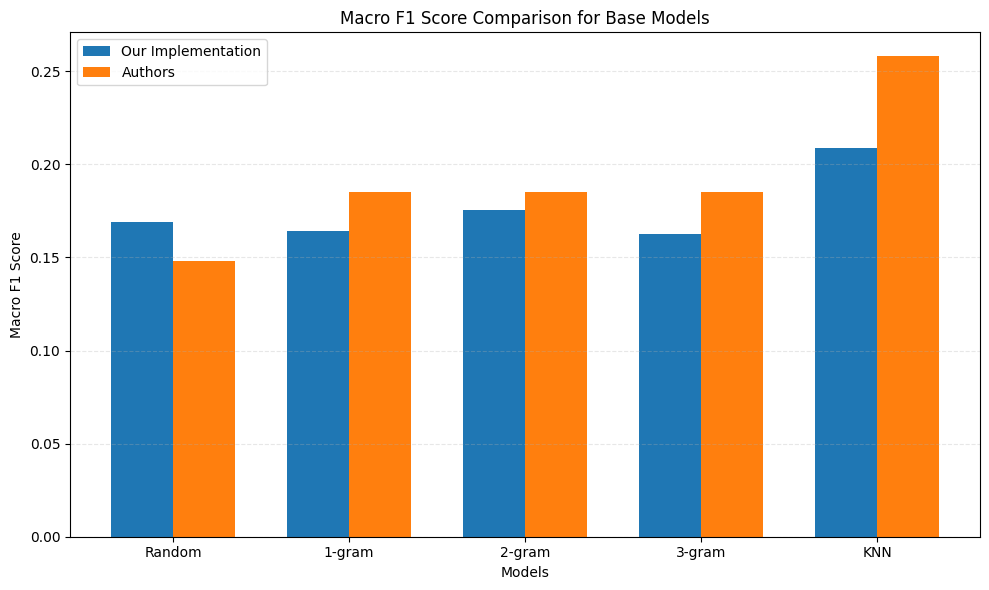

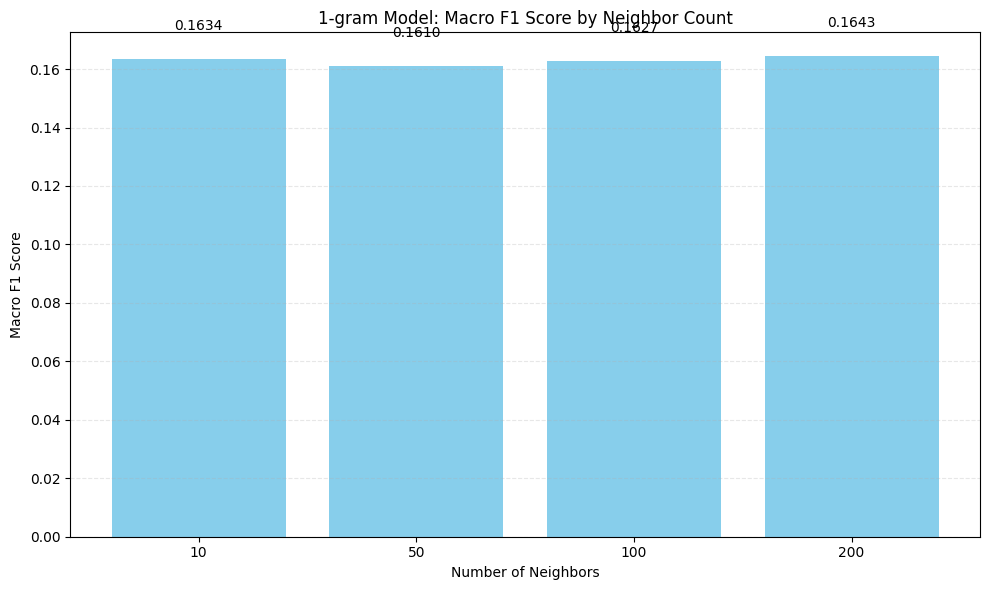

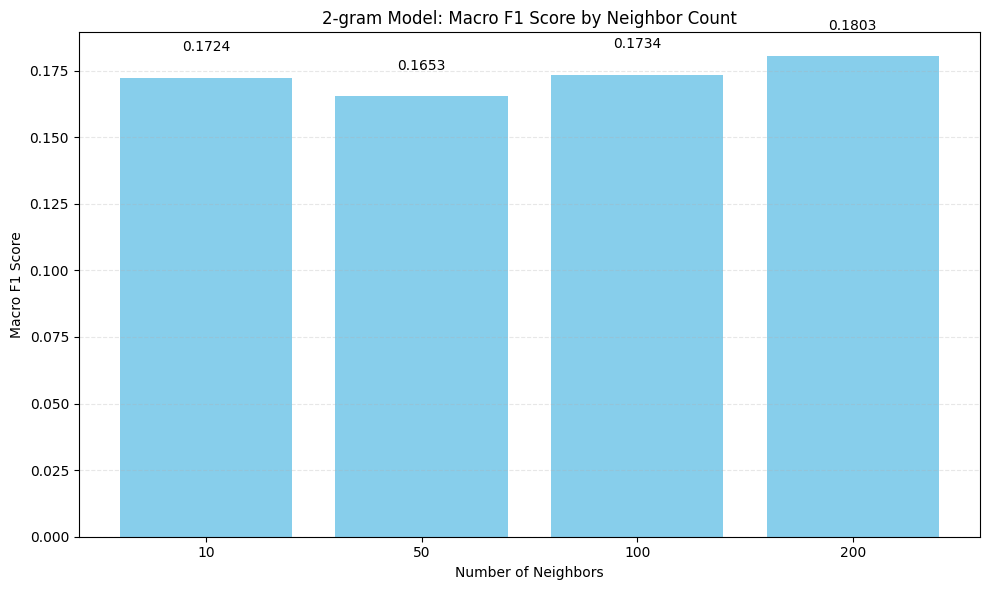

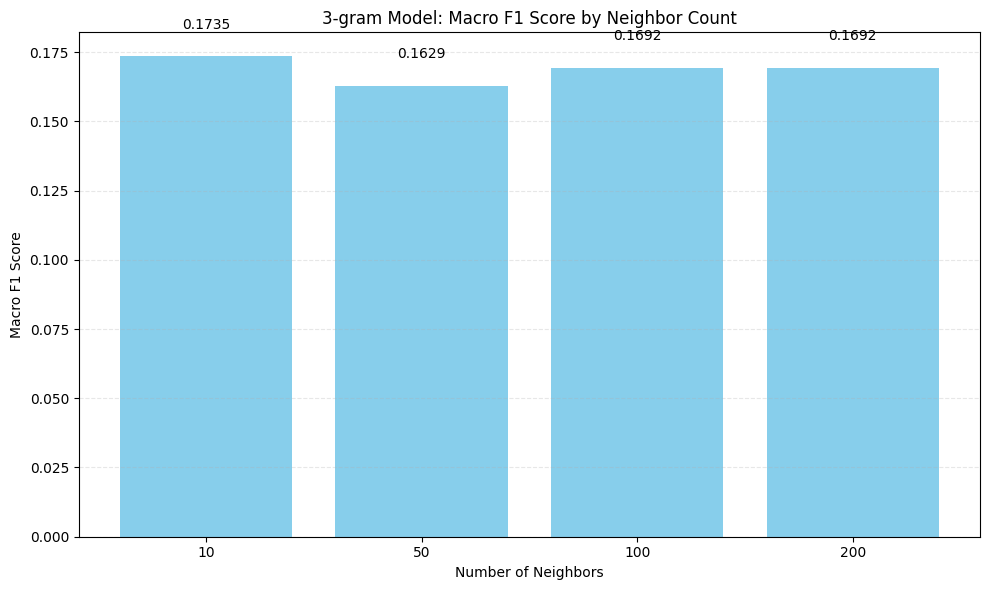

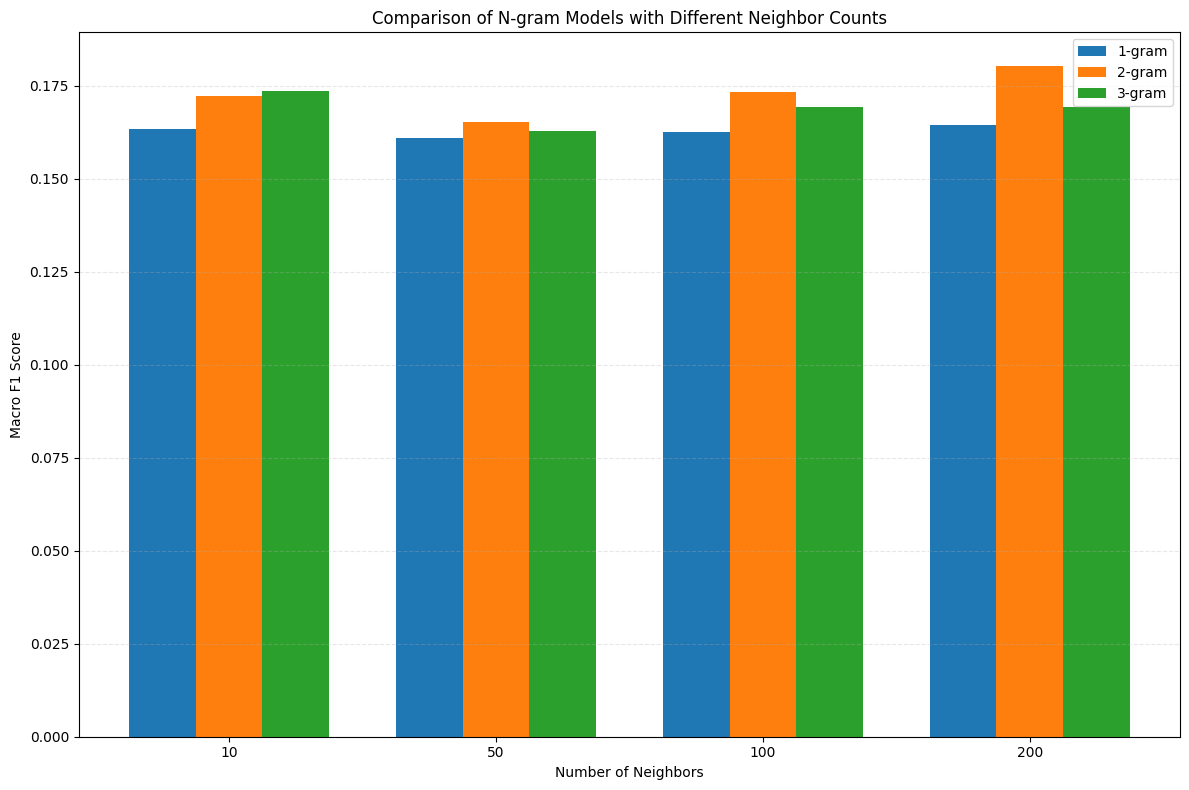

In [12]:
# Import necessary libraries
print("\nImporting required libraries...")

# Function to evaluate CheXpert labels
def calculate_metrics(true_df, pred_df):
    """
    Calculate evaluation metrics for CheXpert labels.

    Args:
        true_df: DataFrame with ground truth labels
        pred_df: DataFrame with predicted labels

    Returns:
        Dictionary of evaluation metrics
    """
    # Find common indices
    common_indices = true_df.index.intersection(pred_df.index)
    if len(common_indices) == 0:
        # If no common indices found by index, try matching by report text
        if 'Reports' in true_df.columns and 'Reports' in pred_df.columns:
            # Create dictionaries mapping reports to their rows
            true_reports = {report: i for i, report in enumerate(true_df['Reports'].values)}
            pred_reports = {report: i for i, report in enumerate(pred_df['Reports'].values)}
            # Find common reports
            common_reports = set(true_reports.keys()).intersection(set(pred_reports.keys()))
            if common_reports:
                print(f"Found {len(common_reports)} common reports by text matching")
                # Extract rows with common reports
                true_subset = true_df.loc[[true_reports[report] for report in common_reports]]
                pred_subset = pred_df.loc[[pred_reports[report] for report in common_reports]]
            else:
                # No matching by text either, try using the first rows
                print("No common samples found. Using first min(len1, len2) rows.")
                min_rows = min(len(true_df), len(pred_df))
                true_subset = true_df.iloc[:min_rows]
                pred_subset = pred_df.iloc[:min_rows]
        else:
            # No reports column, try matching row by row
            print("No common indices found. Using first min(len1, len2) rows.")
            min_rows = min(len(true_df), len(pred_df))
            true_subset = true_df.iloc[:min_rows]
            pred_subset = pred_df.iloc[:min_rows]
    else:
        print(f"Found {len(common_indices)} common indices")
        true_subset = true_df.loc[common_indices]
        pred_subset = pred_df.loc[common_indices]

    # Get all categories except 'Reports'
    categories = [col for col in true_subset.columns if col != 'Reports']

    # Ensure all categories exist in both dataframes
    eval_categories = [col for col in categories if col in true_subset.columns and col in pred_subset.columns]

    # Fill missing values with -2 (not mentioned)
    true_subset = true_subset[eval_categories].fillna(-2)
    pred_subset = pred_subset[eval_categories].fillna(-2)

    # For accuracy: Calculate per-category accuracy
    accuracies = {}
    for category in eval_categories:
        accuracy = accuracy_score(true_subset[category], pred_subset[category])
        accuracies[category] = accuracy

    # For precision: Calculate per-category precision (for positive class only)
    true_binary = (true_subset == 1).astype(int)
    pred_binary = (pred_subset == 1).astype(int)

    precisions = {}
    for category in eval_categories:
        if sum(pred_binary[category]) > 0:  # Only if there are predicted positives
            precision = precision_score(true_binary[category], pred_binary[category], zero_division=0)
            precisions[category] = precision
        else:
            precisions[category] = 0.0

    # For F1: Calculate per-category F1
    f1_scores = {}
    for category in eval_categories:
        f1 = f1_score(true_binary[category], pred_binary[category], zero_division=0)
        f1_scores[category] = f1

    # Calculate macro averages
    macro_accuracy = np.mean(list(accuracies.values()))
    macro_precision = np.mean(list(precisions.values()))
    macro_f1 = np.mean(list(f1_scores.values()))

    # Calculate micro averages (overall)
    micro_f1 = f1_score(true_binary.values.flatten(), pred_binary.values.flatten(), zero_division=0)

    # Return all metrics
    return {
        'category_f1': f1_scores,
        'category_precision': precisions,
        'category_accuracy': accuracies,
        'macro_accuracy': macro_accuracy,
        'macro_precision': macro_precision,
        'macro_f1': macro_f1,
        'micro_f1': micro_f1,
        'eval_categories': eval_categories
    }

# Load labeled files
print("\nLoading labeled files...")
reference_df = pd.read_csv(os.path.join(output_dir, 'labeled_reference.csv'))
print(f"Reference shape: {reference_df.shape}")

# Get categories from reference
categories = [col for col in reference_df.columns if col != 'Reports']
print(f"\nCategories: {categories}")

# Dictionary to store all model results
models_metrics = {}

# Evaluate base models first
base_models = {
    'Random': 'labeled_random.csv',
    '1-gram': 'labeled_1-gram.csv',
    '2-gram': 'labeled_2-gram.csv',
    '3-gram': 'labeled_3-gram.csv',
    'KNN': 'labeled_1nn_reports.csv'
}

print("\nEvaluating base models...")
for model_name, file_name in base_models.items():
    file_path = os.path.join(output_dir, file_name)
    if os.path.exists(file_path):
        print(f"\nEvaluating {model_name} Model...")
        model_df = pd.read_csv(file_path)
        print(f"{model_name} shape: {model_df.shape}")
        models_metrics[model_name] = calculate_metrics(reference_df, model_df)
    else:
        print(f"Warning: {file_name} not found, skipping {model_name} evaluation")

# Evaluate n-gram models with different neighbor counts
print("\nEvaluating n-gram models with different neighbor counts...")
for n in [1, 2, 3]:
    for k in [10, 50, 100, 200]:
        model_name = f"{n}-gram_{k}nn"
        file_name = f"labeled_{model_name}.csv"
        file_path = os.path.join(output_dir, file_name)

        if os.path.exists(file_path):
            print(f"\nEvaluating {model_name} Model...")
            model_df = pd.read_csv(file_path)
            print(f"{model_name} shape: {model_df.shape}")
            models_metrics[model_name] = calculate_metrics(reference_df, model_df)
        else:
            print(f"Warning: {file_name} not found, skipping {model_name} evaluation")

# Print summary results for all models
print("\n===== Summary Results =====")
for model_name, metrics in models_metrics.items():
    print(f"\n{model_name} Model:")
    print(f"  Macro Accuracy: {metrics['macro_accuracy']:.4f}")
    print(f"  Macro Precision: {metrics['macro_precision']:.4f}")
    print(f"  Macro F1: {metrics['macro_f1']:.4f}")
    print(f"  Micro F1: {metrics['micro_f1']:.4f}")

# Compare with authors' results for base models
print("\n===== Comparison with Authors' Results =====")
authors_results = {
    'Random': {'macro_f1': 0.148},
    '1-gram': {'macro_f1': 0.185},
    '2-gram': {'macro_f1': 0.185},
    '3-gram': {'macro_f1': 0.185},
    'KNN': {'macro_f1': 0.258}
}

for model_name in base_models:
    if model_name in models_metrics:
        our_f1 = models_metrics[model_name]['macro_f1']
        authors_f1 = authors_results[model_name]['macro_f1']
        print(f"{model_name} model macro-F1: Ours = {our_f1:.4f}, Authors = {authors_f1:.4f}")

# Create table of per-category F1 scores for base models
print("\n===== Per-Category F1 Scores for Base Models =====")
f1_data = {'Category': categories}
for model_name in base_models:
    if model_name in models_metrics:
        f1_data[model_name] = [models_metrics[model_name]['category_f1'].get(cat, np.nan) for cat in categories]

f1_table = pd.DataFrame(f1_data)
print(f1_table)

# Create visualization for Macro F1 Comparison of base models
plt.figure(figsize=(10, 6))
base_models_list = [m for m in base_models if m in models_metrics]
our_f1_values = [models_metrics[model]['macro_f1'] for model in base_models_list]
authors_f1_values = [authors_results[model]['macro_f1'] for model in base_models_list]

x = np.arange(len(base_models_list))
width = 0.35

plt.bar(x - width/2, our_f1_values, width, label='Our Implementation')
plt.bar(x + width/2, authors_f1_values, width, label='Authors')

plt.xlabel('Models')
plt.ylabel('Macro F1 Score')
plt.title('Macro F1 Score Comparison for Base Models')
plt.xticks(x, base_models_list)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'base_models_f1_comparison.png'))
print("Saved base models F1 comparison visualization")

# Create comparison visualizations for n-gram models with different neighbor counts
print("\n===== Visualizing Results for N-gram Models with Different Neighbor Counts =====")

# Group by n-gram (1, 2, 3)
for n in [1, 2, 3]:
    # Filter models for this n-gram
    n_gram_models = [m for m in models_metrics.keys() if m.startswith(f"{n}-gram_") and "nn" in m]

    if not n_gram_models:
        print(f"No results for {n}-gram models with different neighbor counts")
        continue

    # Extract neighbor counts and sort
    neighbor_counts = [int(m.split('_')[1].replace('nn', '')) for m in n_gram_models]
    sorted_indices = np.argsort(neighbor_counts)
    sorted_models = [n_gram_models[i] for i in sorted_indices]
    sorted_neighbor_counts = [neighbor_counts[i] for i in sorted_indices]

    # Get macro F1 scores
    sorted_f1_scores = [models_metrics[model]['macro_f1'] for model in sorted_models]

    # Create visualization
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sorted_models)), sorted_f1_scores, color='skyblue')

    plt.xlabel('Number of Neighbors')
    plt.ylabel('Macro F1 Score')
    plt.title(f'{n}-gram Model: Macro F1 Score by Neighbor Count')
    plt.xticks(range(len(sorted_models)), sorted_neighbor_counts)
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Add values on top of bars
    for i, v in enumerate(sorted_f1_scores):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{n}-gram_f1_by_neighbors.png'))
    print(f"Saved {n}-gram F1 by neighbors visualization")

# Create comparison across all n-gram models and neighbor counts
plt.figure(figsize=(12, 8))

# Organize data by neighbor count
neighbor_counts = [10, 50, 100, 200]
bar_positions = np.arange(len(neighbor_counts))
width = 0.25  # Width of each bar

# Plot each n-gram series
for i, n in enumerate([1, 2, 3]):
    f1_values = []
    for k in neighbor_counts:
        model_key = f"{n}-gram_{k}nn"
        if model_key in models_metrics:
            f1_values.append(models_metrics[model_key]['macro_f1'])
        else:
            f1_values.append(0)  # Use 0 for missing values

    offset = (i - 1) * width
    plt.bar(bar_positions + offset, f1_values, width, label=f'{n}-gram')

plt.xlabel('Number of Neighbors')
plt.ylabel('Macro F1 Score')
plt.title('Comparison of N-gram Models with Different Neighbor Counts')
plt.xticks(bar_positions, neighbor_counts)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'all_ngram_f1_by_neighbors.png'))
print("Saved all n-gram models F1 by neighbors visualization")

# Create a comprehensive summary table for n-gram models with different neighbor counts
print("\n===== Summary Table for N-gram Models with Different Neighbor Counts =====")
neighbor_summary_data = []

for n in [1, 2, 3]:
    for k in [10, 50, 100, 200]:
        model_key = f"{n}-gram_{k}nn"
        if model_key in models_metrics:
            row = {
                'Model': f"{n}-gram",
                'Neighbors': k,
                'Macro Accuracy': models_metrics[model_key]['macro_accuracy'],
                'Macro Precision': models_metrics[model_key]['macro_precision'],
                'Macro F1': models_metrics[model_key]['macro_f1'],
                'Micro F1': models_metrics[model_key]['micro_f1']
            }
            neighbor_summary_data.append(row)

if neighbor_summary_data:
    neighbor_summary_df = pd.DataFrame(neighbor_summary_data)
    print(neighbor_summary_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    # Save neighbor summary table
    neighbor_summary_df.to_csv(os.path.join(output_dir, 'chexpert_summary_by_neighbors.csv'), index=False)
    print(f"Saved neighbor summary table to {os.path.join(output_dir, 'chexpert_summary_by_neighbors.csv')}")
else:
    print("No results found for n-gram models with different neighbor counts")

print("\nChexpert evaluation completed successfully!")